# Analyzing CIA Factbook Data Using SQL
 ----
 
## Introduction

In this project, I'm going to analyze data from the [CIA World Factbook](https://www.cia.gov/the-world-factbook/countries/), originally conceived in 1941 it has gone through several iterations. The World Factbook serves as a collection of stastics summarizing the demographics, geography, government, economy and military of 267 international entities. Updates are frequently launched on *The World Factbook* website to coincide with everchanging statistics. 

I am analyzing a condensed version of the World Factbook in the form of the database `factbook.db` from the 2015 iteration of the World Factbook which can be downloaded [here](https://dsserver-prod-resources-1.s3.amazonaws.com/257/factbook.db). 

The goal of this analysis is to gain some familiarity with the dataset by way of analyzing some simple population metrics. 

In [1]:
%%capture
%load_ext sql
%sql sqlite:///factbook.db

In [2]:
%%sql
SELECT * 
  FROM sqlite_master
 WHERE type='table';

 * sqlite:///factbook.db
Done.


type,name,tbl_name,rootpage,sql
table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, ""code"" varchar(255) NOT NULL, ""name"" varchar(255) NOT NULL, ""area"" integer, ""area_land"" integer, ""area_water"" integer, ""population"" integer, ""population_growth"" float, ""birth_rate"" float, ""death_rate"" float, ""migration_rate"" float)"


In [3]:
%%sql 
SELECT * 
  FROM facts
 LIMIT 5;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
2,al,Albania,28748,27398,1350,3029278,0.3,12.92,6.58,3.3
3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.0
5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


Here are the descriptions for some of the columns in the `facts` table: 

* **name** - the name of the country
* **area** - the country's total area (both land and water)
* **area_land** - the country's land area in square kilometers
* **area_water** - the country's waterarea in square kilometers
* **population** - the country's population
* **population_growth** - the country's population growth as a percentage
* **birth_rate** - the country's birth rate, or the number of birthds per year per 1,000 people
* **death_rate** - the country's death rate, or the number of death per year per 1,000 people

I'll begin by calculating some summary statistics to look for any outlier countries in the dataset.

To do so I'll write a single query that returns information on the following metrics: 

    * Minimum population 
    * Maximum population
    * Minimum population growth
    * Maximum population growth 

In [4]:
%%sql
SELECT MIN(population) AS min_pop, 
       MAX(population) AS max_pop, 
       MIN(population_growth) AS min_pop_growth, 
       MAX(population_growth) max_pop_growth
  FROM facts;

 * sqlite:///factbook.db
Done.


min_pop,max_pop,min_pop_growth,max_pop_growth
0,7256490011,0.0,4.02


There are a few interesting values in the summary statistics output above. 
* There's a country with a population of `0`
* There's a country with a population of `7256490011` (or more than 7.2 billion people) 

Let's further explore the outlier countries by using subqueries to zoom in on those countries of note without using any specific value. 

In [5]:
%%sql
SELECT *
  FROM facts
 WHERE population == (SELECT MIN(population) 
                        FROM facts);

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
250,ay,Antarctica,None,280000,None,0,None,None,None,None


So based on the table above, the country in question that has a population of `0` is `Antarctica`. 

Infromation from the CIA Factbook states the following regarding Anatarctica's lack of population: 

    "no indigenous inhabitants, but there are both year-round and summer-only staffed research stations"


In [6]:
%%sql
SELECT * 
  FROM facts
 WHERE population == (SELECT MAX(population)
                        FROM facts);

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None


Based on the output, the `facts` table contains a row for `World` which seems to be a sum of all country populations and explains the population of over 7.2 billion. I'll recaculate them and exclude this row as it has no doubt skewed the previous summary statistics in previous cells. seems to be a sum of all country populations. 

In [7]:
%%sql
SELECT MIN(population) AS min_pop,
       MAX(population) AS max_pop,
       MIN(population_growth) AS min_pop_growth,
       MAX(population_growth) AS max_pop_growth
  FROM facts
 WHERE name <> 'World';

 * sqlite:///factbook.db
Done.


min_pop,max_pop,min_pop_growth,max_pop_growth
0,1367485388,0.0,4.02


## Exploring Average Population and Area

The `facts` table seems to contain a row for the whole world (population of over 7.2 billion) and a row for Antarctica (population of only 0). 

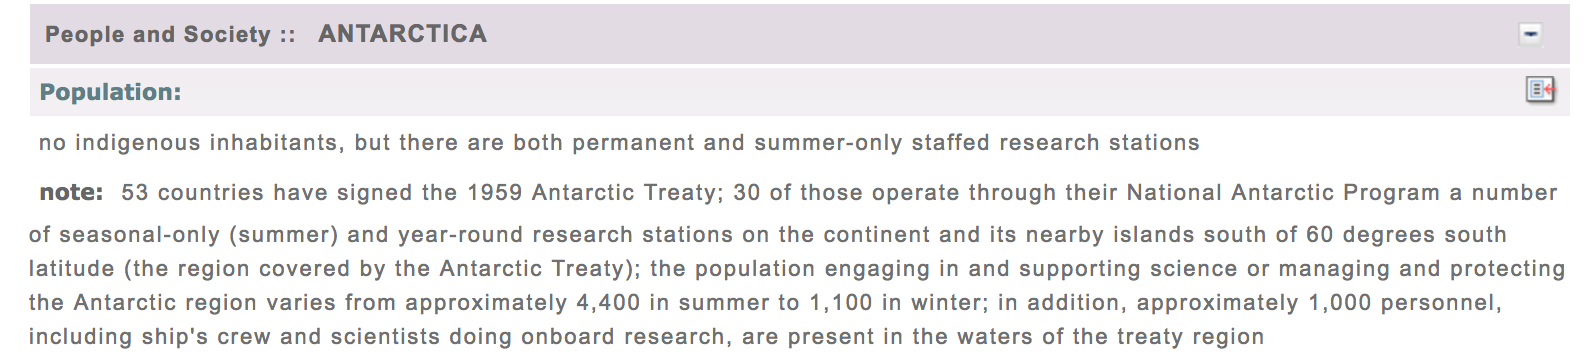

Based on this information, the summary statistics will be recalculated to exclude the row for the whole world. 

In [8]:
%%sql
SELECT AVG(population) AS avg_pop, AVG(area) AS avg_area
  FROM facts
 WHERE name <> 'World';


 * sqlite:///factbook.db
Done.


avg_pop,avg_area
32242666.56846473,555093.546184739


Let's find out the Top 5 most populated countries as well as the Top 5 least populated countries.  

----

First let's find the Top 5 MOST populated countries:

In [25]:
%%sql
SELECT name, population AS top5_population
  FROM facts
WHERE name != 'World'
ORDER BY population DESC
LIMIT 5;

 * sqlite:///factbook.db
Done.


name,top5_population
China,1367485388
India,1251695584
European Union,513949445
United States,321368864
Indonesia,255993674


There's an issue with this output, the European Union is included although it's not a country, it will be excluded to produce a proper output. 

In [27]:
%%sql
SELECT name, population AS top5_population
  FROM facts
WHERE name != 'World'
  AND name != 'European Union'
ORDER BY population DESC
LIMIT 5;

 * sqlite:///factbook.db
Done.


name,top5_population
China,1367485388
India,1251695584
United States,321368864
Indonesia,255993674
Brazil,204259812


The output above shows that the most populated country is **China**, followed closely by **India**, then by a difference of nearly 1 billion is the **United States**, **Indonesia**, and **Brazil**. 

Now on the other end of the spectrum the Top 5 LEAST populated countries are as follows:

In [28]:
%%sql
SELECT name, population AS bottom5_population
  FROM facts
WHERE name != 'Antarctica'
  AND population NOT NULL
ORDER BY population
LIMIT 5;

 * sqlite:///factbook.db
Done.


name,bottom5_population
Pitcairn Islands,48
Cocos (Keeling) Islands,596
Holy See (Vatican City),842
Niue,1190
Tokelau,1337


The Top 5 LEAST populated countries make sense upon further research due to their locations, four out of the five listed are islands in very remote parts of the world's oceans (**Pitcairn Islands**, **Cocos Islands**, **Niue** and **Tokelau**. The city-state of the **Vatican** is the headquarters of the Roman Catholic Church and lies completely surrounded within Rome, Italy. 

## Finding Densely Population Countries

To finish, I'll build on the query for average population and area from the previous cell to find countries that are densely populated. I'll identify countries that have the following: 

* Above-average values for population
* Below-average values for area



In [9]:
%%sql
SELECT name, population, area
  FROM facts
 WHERE population > (SELECT AVG(population)
                        FROM facts
                       WHERE name <> 'World')
 AND area < (SELECT AVG(area)
                 FROM facts
               WHERE name <> '');
 

 * sqlite:///factbook.db
Done.


name,population,area
Bangladesh,168957745,148460
Germany,80854408,357022
Iraq,37056169,438317
Italy,61855120,301340
Japan,126919659,377915
"Korea, South",49115196,99720
Morocco,33322699,446550
Philippines,100998376,300000
Poland,38562189,312685
Spain,48146134,505370


The World Factbook dataset is one full of opportunity for expanded analysis. There are so many questions that can be asked and answered due to the complexity of the dataset. For a dataset of this kind it might be best to have a narrow scope with which to continue analysis.

For example these questions can be answered and analyzed: 

*    Which country has the most people? Which country has the highest growth rate?
*    Which countries have the highest ratios of water to land? Which countries have more water than land?
*    Which countries will add the most people to their populations next year?
*    Which countries have a higher death rate than birth rate?
*    Which countries have the highest population/area ratio, and how does it compare to list we found in the previous screen?
